In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sms
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(12,8)})

### Задание:
Вы работаете в приложении по доставке готовых продуктов. К вам пришёл коллега с результатами двух А/Б-тестов:

- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные фотографии, либо квадратные;

- Во втором: была обновлена кнопка заказа, и часть пользователей видела старый вариант, а часть – новый.

Ваша задача – помочь коллеге проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

**Справочные данные по первому датафрейму:**
```
id – id клиента в эксперименте;
group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные,
C – прямоугольные 12:4);
events – сколько блюд суммарно было заказано за период.
```

In [3]:
# Загружем датафрейм с результатами первого А/Б-теста.

dir_path = '~/data_files/'
df1 = pd.read_csv(dir_path + 'test1.csv')
df1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [4]:
# Взглянем на размер датафрейма.

df1.shape

(30000, 3)

In [5]:
# Определим типы полей датафрейма.

df1.dtypes

id         int64
group     object
events     int64
dtype: object

In [6]:
# Определим есть ли в нашем датафрейме записи, не относящиеся ни к одному из доступных типов (NaN значения).

df1.isna().sum()

id        0
group     0
events    0
dtype: int64

In [7]:
# Посмотрим на распределение значений в каждой из тестовых групп.

df1.group.value_counts()

B    10000
A    10000
C    10000
Name: group, dtype: int64

In [8]:
# Разделим датасет по группам.

group_a = df1[df1.group == "A"]
group_b = df1[df1.group == "B"]
group_c = df1[df1.group == "C"]

Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [9]:
st.levene(group_a.events, group_b.events, group_c.events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [10]:
pg.homoscedasticity(data=df1, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


Тест Левена выдал p-value > 0.05, поэтому мы не отклоняем нулевую гипотезу. Следовательно, дисперсии внутри групп можно считать одинаковыми (гомогенными).

Теперь убедимся, что данные распределены нормально, ипользуя специальный тест на нормальность, а также QQ-график.

In [11]:
st.normaltest(group_a.events)

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)

In [12]:
st.normaltest(group_b.events)

NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)

In [13]:
st.normaltest(group_c.events)

NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)

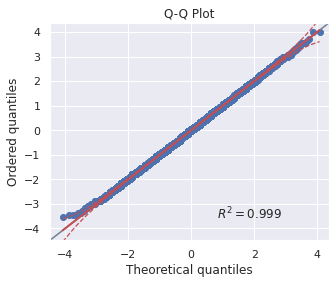

In [14]:
pg.qqplot(df1.events)

Согласно проведённым тестам, распределения во всех 3 группах являются нормальными. QQ-график также подтверждает это, поскольку он сравнивает два распределения вероятностей (наше и идеально нормальное) путём построения совместных квантилей. И раз расхождения между этими 2 распределениями практически не видны (все значения нашего распределения лежат на диагональной прямой), то можно утверждать, что наше распределение вероятностей без разбиения на группы тоже является нормальным.

Поскольку в А/Б-тесте участвует 3 группы, логично сперва провети классический дисперсионный анализ (ANOVA), после чего уже проводить попарный t-тест в случае необходимости.

In [15]:
pg.anova(data=df1, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


Поскольку p-value оказалось равно 0, мы вынуждены признать, что между нашими группами есть отличия. Осталось выяснить - между какими именно группами. Для этого надо провести попарный t-тест.

In [16]:
# Используем поправку Холма для p-value,
# поскольку мы проводим множественное сравнение.

pg.pairwise_ttests(data=df1, dv='events', between='group', padjust='holm')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,7.500262e-50,holm,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,1.024138


Можем применить поправку на множественные сравнения в виде использования критерия Тьюки.

In [17]:
sms.multicomp.pairwise_tukeyhsd(df1['events'], df1['group']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


В результате выясняется, что все 3 группы попарно различаются. Изобразим графики-скрипки для каждой из групп, чтобы понять, в какую сторону значимо изменилось количество заказов для тестовой группы B.

Text(0, 0.5, 'число покупок')

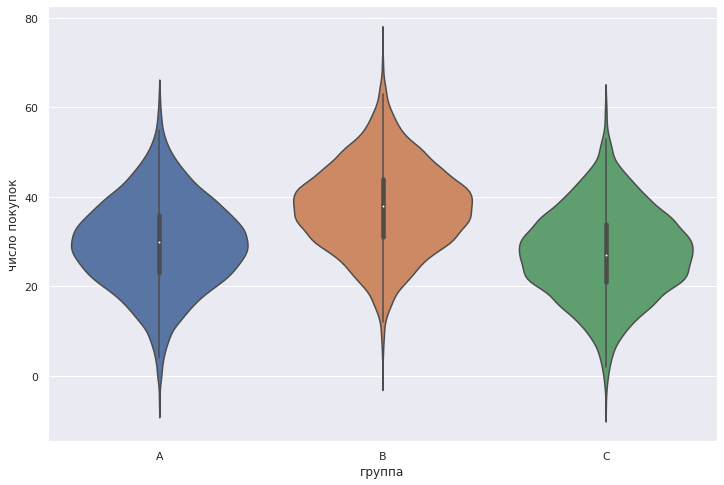

In [18]:
sns.violinplot(data=df1, y='events', x='group')
plt.xlabel('группа')
plt.ylabel('число покупок')

График-скрипка для тестовой группы B (квадратные картинки блюд) показывает увеличение заказов, поэтому нулевую гипотезу об отсутствии различий между формой картинок можно отвергнуть.

**Вывод №1:**

По результатам анализа тестовая группа, представляющая из себя квадратный формат картинок блюд, показывает увеличение среднего числа заказов, поэтому можно внедрять новый вид отображения картинок блюд в приложение.

**Справочные данные по второму датафрейму:**
```
id – id клиента в эксперименте;
segment – сегмент;
group – вид кнопки (control – старая версия, test – новая версия);
events – сколько блюд суммарно было заказано за период.
```

In [19]:
# Загружем датафрейм с результатами второго А/Б-теста.

df2 = pd.read_csv(dir_path + 'test2.csv')
df2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [20]:
# Взглянем на размер датафрейма.

df2.shape

(100000, 4)

In [21]:
# Определим типы полей датафрейма.

df2.dtypes

id           int64
group       object
segment     object
events     float64
dtype: object

In [22]:
# Преобразуем количество покупок (событий) к целочисленному типу данных.

df2['events'] = df2.events.astype('int64')
df2.dtypes

id          int64
group      object
segment    object
events      int64
dtype: object

In [23]:
# Определим есть ли в нашем датафрейме записи, не относящиеся ни к одному из доступных типов (NaN значения).

df2.isna().sum()

id         0
group      0
segment    0
events     0
dtype: int64

In [24]:
# Посмотрим на распределение значений в каждой из тестовых групп.

df2.group.value_counts()

control    50000
test       50000
Name: group, dtype: int64

In [25]:
# Посмотрим на распределение значений для каждого сегмента.

df2.segment.value_counts()

low     80000
high    20000
Name: segment, dtype: int64

Text(0, 0.5, '')

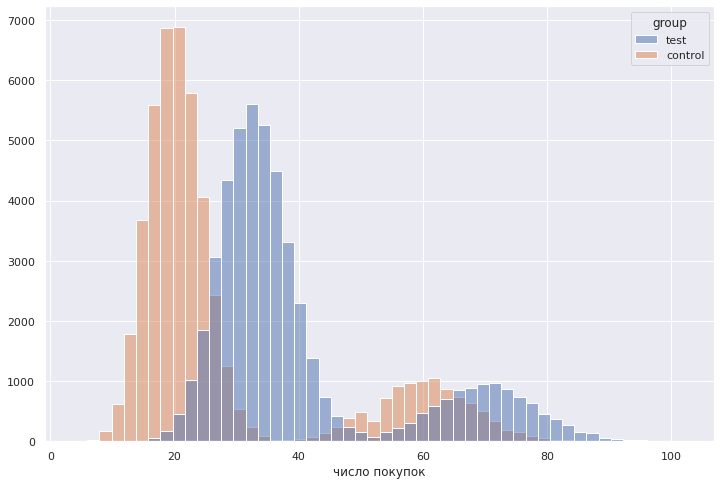

In [26]:
# Изобразим гистограмму распределения значений покупок для каждой из тестовых групп.

sns.histplot(data=df2, x='events', hue='group', bins=50)
plt.xlabel('число покупок')
plt.ylabel('')

In [27]:
# Посчитаем среднее, медиану и стандартное отклонение числа покупок
# в разбивке по группе и по сегменту пользователя.

df2.groupby(['group', 'segment'], as_index=False) \
    .agg({'events' : ['count', 'mean', 'median', 'std']})

group segment events                            
                    count       mean median       std
0  control    high  10000  59.970800     60  7.805347
1  control     low  40000  20.031575     20  4.473576
2     test    high  10000  69.938500     70  8.403974
3     test     low  40000  33.025925     33  5.720845

In [28]:
# Измерим разницу между группами t-тестом с поправкой Тьюки.

pg.pairwise_tukey(data=df2, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control,test,28.01942,40.40844,-12.38902,0.10409,-119.021936,0.001,-0.752755


In [29]:
# Измерим разницу между сегментами t-тестом с поправкой Тьюки.

pg.pairwise_tukey(data=df2, dv='events', between='segment')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,high,low,64.95465,26.52875,38.4259,0.067541,568.923864,0.001,4.497704


И между группами, и между сегментами есть статистически значимая разница. Однако, поскольку мы хотим проверить совместный эффект нескольких переменных (group и segment) на целевую метрику числа продаж (events), необходимо использовать многофакторный дисперсионный анализ (MANOVA).

In [30]:
model = smf.ols(formula='events ~ group + segment + group:segment', data=df2).fit()
sms.anova.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group:segment,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [31]:
# Можно объединить колонки group и segment в новое поле combination,
# чтобы перейти от многофакторного дисперсионного анализа к однофакторному.

df2['combination'] = df2['group'] + ' + ' + df2['segment']
df2.head()

,id,group,segment,events,combination
0,83440,test,high,78,test + high
1,96723,test,high,71,test + high
2,68719,test,high,80,test + high
3,50399,test,high,80,test + high
4,95613,test,high,78,test + high


In [32]:
# Проводим однофакторный дисперсионный анализ с поправкой Тьюки
# над новым полем combination.

sms.multicomp.pairwise_tukeyhsd(df2['events'], df2['combination']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control + high,control + low,-39.9392,0.001,-40.1073,-39.7711,True
control + high,test + high,9.9677,0.001,9.7551,10.1803,True
control + high,test + low,-26.9449,0.001,-27.113,-26.7768,True
control + low,test + high,49.9069,0.001,49.7388,50.075,True
control + low,test + low,12.9944,0.001,12.888,13.1007,True
test + high,test + low,-36.9126,0.001,-37.0807,-36.7445,True


Text(0, 0.5, 'число покупок')

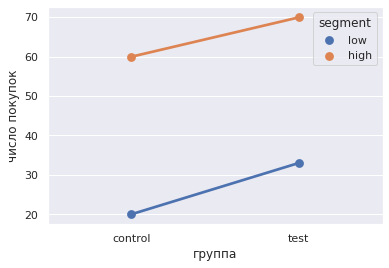

In [33]:
# Уменьшим размер графика.
sns.set(rc={'figure.figsize':(6,4)})

# Изобразим график изменений значений по каждому сегменту в разрезе групп.
sns.pointplot(data=df2.sort_values('group', ascending=True), x='group', y='events', hue='segment')
plt.xlabel('группа')
plt.ylabel('число покупок')

**Вывод №2:**

По результатам попарного сравнения можно наблюдать, что все комбинации групп и сегментов попарно различаются. Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой. Разница между значением у тестовой группы и контрольной группы для сегмента low равна примерно 13 покупкам. Разница между значением у тестовой группы и контрольной группы для сегмента high равна примерно 10 покупкам. Поэтому можно смело выкатывать новую версию приложения.